# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

Trained with an updated model architecture, CNNMFCCs3


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_3'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs3 import CNNMFCCs3

model = CNNMFCCs3()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs3(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.51it/s, Loss=0.9569300413131714, Elapsed=1.6911s, ETA=0.0000s]


Epoch 1 completed in 7.8924s
Train Loss: 1.2965454355829713 - Train Accuracy: 42.31021460392122
Validation Loss: 1.0806004659334818 - Validation Accuracy: 50.981426762346985

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.61it/s, Loss=0.8927372097969055, Elapsed=1.7152s, ETA=0.0000s]

Epoch 2 completed in 7.6647s
Train Loss: 0.9950775783186014 - Train Accuracy: 55.55279166007101
Validation Loss: 0.8926547280947368 - Validation Accuracy: 62.062051498522585

Epoch 3/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.24it/s, Loss=1.5337692499160767, Elapsed=1.7108s, ETA=0.0000s]

Epoch 3 completed in 7.6207s
Train Loss: 0.8879940725130842 - Train Accuracy: 60.54589448452092
Validation Loss: 0.8932030495007833 - Validation Accuracy: 60.658505698607016

EarlyStopping counter: 1/7
Epoch 4/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.36it/s, Loss=0.7083225846290588, Elapsed=1.6965s, ETA=0.0000s]

Epoch 4 completed in 7.0429s
Train Loss: 0.819191661701037 - Train Accuracy: 63.77060672531151
Validation Loss: 0.8099935762087505 - Validation Accuracy: 66.36766568172224

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.55it/s, Loss=0.768176257610321, Elapsed=1.6035s, ETA=0.0000s] 


Epoch 5 completed in 7.2780s
Train Loss: 0.7821347215616634 - Train Accuracy: 65.6023156418896
Validation Loss: 0.78006054798762 - Validation Accuracy: 68.64710848459265

Epoch 6/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.44it/s, Loss=0.46406808495521545, Elapsed=1.6075s, ETA=0.0000s]

Epoch 6 completed in 7.1962s
Train Loss: 0.7421782385407155 - Train Accuracy: 67.35939938038489
Validation Loss: 0.8078189067045848 - Validation Accuracy: 65.66061629379485

EarlyStopping counter: 1/7
Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.66it/s, Loss=0.3448600769042969, Elapsed=1.7198s, ETA=0.0000s]

Epoch 7 completed in 7.0958s
Train Loss: 0.7101683685545287 - Train Accuracy: 68.80893693041767
Validation Loss: 0.7460968931516011 - Validation Accuracy: 66.5470662726889

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.76it/s, Loss=0.3287998139858246, Elapsed=1.5680s, ETA=0.0000s] 

Epoch 8 completed in 7.4154s
Train Loss: 0.6890261118122608 - Train Accuracy: 69.83559847131453
Validation Loss: 0.6931401693820953 - Validation Accuracy: 71.20092866188266

Epoch 9/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.66it/s, Loss=0.3393983244895935, Elapsed=1.5660s, ETA=0.0000s]

Epoch 9 completed in 7.2580s
Train Loss: 0.6602529032381973 - Train Accuracy: 70.83738495285046
Validation Loss: 0.747119931379954 - Validation Accuracy: 69.83959476572393

EarlyStopping counter: 1/7
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.58it/s, Loss=0.36985716223716736, Elapsed=1.6626s, ETA=0.0000s]

Epoch 10 completed in 7.2550s
Train Loss: 0.6396862314960171 - Train Accuracy: 71.91831935053482
Validation Loss: 0.7085270249843597 - Validation Accuracy: 69.5335584634867

EarlyStopping counter: 2/7
Epoch 11/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.52it/s, Loss=0.23724649846553802, Elapsed=1.6516s, ETA=0.0000s]


Epoch 11 completed in 7.2544s
Train Loss: 0.6210960499468566 - Train Accuracy: 72.712059881052
Validation Loss: 0.6814191418886185 - Validation Accuracy: 71.96074292950611

Epoch 12/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.53it/s, Loss=0.26323962211608887, Elapsed=1.5878s, ETA=0.0000s]

Epoch 12 completed in 7.1378s
Train Loss: 0.6062668606725042 - Train Accuracy: 73.27740213925512
Validation Loss: 0.6990041434764862 - Validation Accuracy: 71.14816378218659

EarlyStopping counter: 1/7
Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.29it/s, Loss=0.3702718913555145, Elapsed=1.6873s, ETA=0.0000s] 


Epoch 13 completed in 7.0573s
Train Loss: 0.5870021455032977 - Train Accuracy: 73.93093778973791
Validation Loss: 0.6659651831785838 - Validation Accuracy: 72.62558041367666

Epoch 14/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 67.12it/s, Loss=0.46612170338630676, Elapsed=1.5941s, ETA=0.0000s]

Epoch 14 completed in 7.2524s
Train Loss: 0.5744326374778858 - Train Accuracy: 74.38773433436603
Validation Loss: 0.6620214343070984 - Validation Accuracy: 72.60447446179823

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.90it/s, Loss=0.3580496609210968, Elapsed=1.6307s, ETA=0.0000s] 

Epoch 15 completed in 7.2177s
Train Loss: 0.5492208935966382 - Train Accuracy: 75.42344135139413
Validation Loss: 0.7325864088535309 - Validation Accuracy: 70.98986914309835

EarlyStopping counter: 1/7
Epoch 16/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.34it/s, Loss=0.06386703997850418, Elapsed=1.6977s, ETA=0.0000s]


Epoch 16 completed in 8.0179s
Train Loss: 0.5432555554057822 - Train Accuracy: 75.84179462246445
Validation Loss: 0.6476659624775251 - Validation Accuracy: 72.48839172646686

Epoch 17/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.47it/s, Loss=0.08648963272571564, Elapsed=1.5936s, ETA=0.0000s]


Epoch 17 completed in 7.1837s
Train Loss: 0.5227920251946918 - Train Accuracy: 76.35512539291287
Validation Loss: 0.7065440450112025 - Validation Accuracy: 71.35922330097088

EarlyStopping counter: 1/7
Epoch 18/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.70it/s, Loss=0.1924447864294052, Elapsed=1.6878s, ETA=0.0000s] 

Epoch 18 completed in 7.1464s
Train Loss: 0.5092770111870903 - Train Accuracy: 76.78026277108161
Validation Loss: 0.6526050080855688 - Validation Accuracy: 73.24820599409033

EarlyStopping counter: 2/7
Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 57.60it/s, Loss=0.5719022750854492, Elapsed=1.7925s, ETA=0.0000s] 

Epoch 19 completed in 7.4148s
Train Loss: 0.49629028821956217 - Train Accuracy: 77.52199181384411
Validation Loss: 0.7020465127627055 - Validation Accuracy: 71.67581257914732

EarlyStopping counter: 3/7
Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.45it/s, Loss=0.1601552665233612, Elapsed=1.6417s, ETA=0.0000s] 

Epoch 20 completed in 7.6802s
Train Loss: 0.4791034042318432 - Train Accuracy: 78.27955043983627
Validation Loss: 0.6628703443209331 - Validation Accuracy: 73.77585479105107

EarlyStopping counter: 4/7
Epoch 21/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.70it/s, Loss=0.3339155614376068, Elapsed=1.5830s, ETA=0.0000s] 

Epoch 21 completed in 7.2969s
Train Loss: 0.4643707258163849 - Train Accuracy: 78.56222156893784
Validation Loss: 0.7190412378311157 - Validation Accuracy: 72.99493457154918

EarlyStopping counter: 5/7
Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.37it/s, Loss=0.304386168718338, Elapsed=1.7029s, ETA=0.0000s]  


Epoch 22 completed in 7.3979s
Train Loss: 0.45055864217308905 - Train Accuracy: 79.04841591099252
Validation Loss: 0.7283494126796722 - Validation Accuracy: 74.11355002110595

EarlyStopping counter: 6/7
Epoch 23/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.19it/s, Loss=0.156513512134552, Elapsed=1.6923s, ETA=0.0000s]  


Epoch 23 completed in 7.6646s
Train Loss: 0.44084876190031197 - Train Accuracy: 79.48938287239095
Validation Loss: 0.6981832905610402 - Validation Accuracy: 74.0713381173491

EarlyStopping counter: 7/7
🔁 Early stopping triggered!


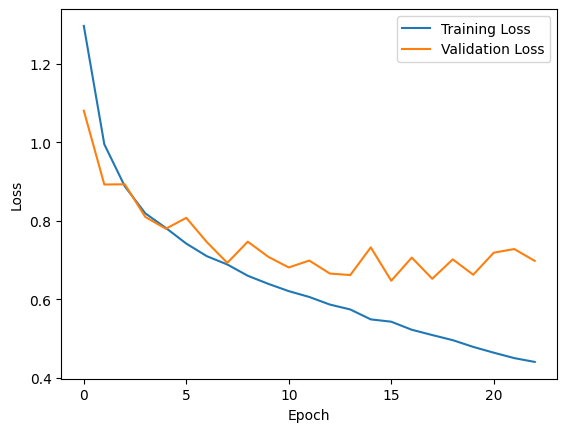

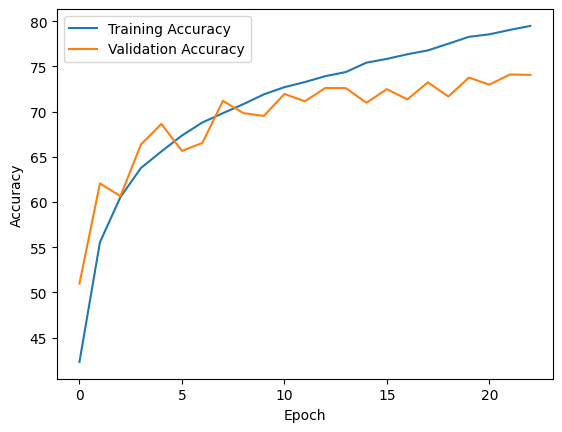

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 39.91it/s]


Test Accuracy: 0.7319
Test Precision: 0.7476
Test Recall: 0.7319
Test F1-score: 0.7314

              precision    recall  f1-score   support

       Anger       0.80      0.77      0.78       916
       Bored       0.80      0.86      0.82      1098
     Disgust       0.59      0.62      0.61       291
        Fear       0.44      0.72      0.54       308
       Happy       0.85      0.57      0.68      1914
     Neutral       0.71      0.67      0.69      2226
    Question       0.83      0.89      0.86      1139
         Sad       0.67      0.81      0.73       857
    Surprise       0.64      0.82      0.72       728

    accuracy                           0.73      9477
   macro avg       0.70      0.75      0.71      9477
weighted avg       0.75      0.73      0.73      9477



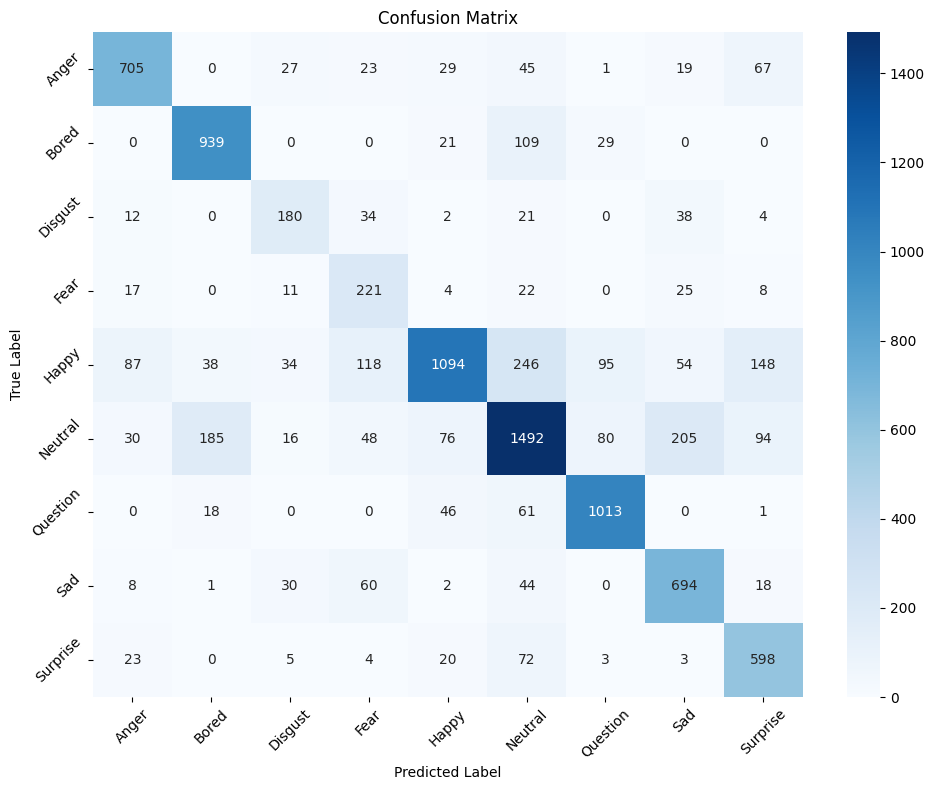

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)